# SAM on ants counting

## Install dependencies

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!python -m pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

# https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb#scrollTo=CS_WhY60XMNL

In [59]:
import os


os.chdir(os.path.join(ROOT, "models"))

In [60]:
# https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/automated-dataset-annotation-and-evaluation-with-grounding-dino-and-sam.ipynb
!git clone https://github.com/IDEA-Research/GroundingDINO.git
!cd GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

Cloning into 'GroundingDINO'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 314 (delta 42), reused 48 (delta 33), pack-reused 228
Receiving objects: 100% (314/314), 12.35 MiB | 1.39 MiB/s, done.
Resolving deltas: 100% (147/147), done.
fatal: reference is not a tree: 57535c5a79791cb76e36fdb64975271354f10251
ERROR: file:///Users/niche/Library/CloudStorage/OneDrive-VirginiaTech/_03_Papers/2023/finding_ants/models does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


## Environment

In [32]:
import os
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
ROOT = os.path.join("..")
CHECKPOINT_PATH = os.path.join(ROOT, "models", "sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('mps')
MODEL_TYPE = "vit_h"
PATH_IMG = os.path.join(ROOT, "data", "raw", "fire_ant_activity", "A1", "A1_1.JPEG")

## Image processing

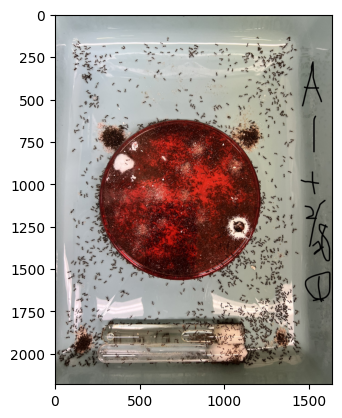

In [44]:
image_bgr = cv2.imread(PATH_IMG)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

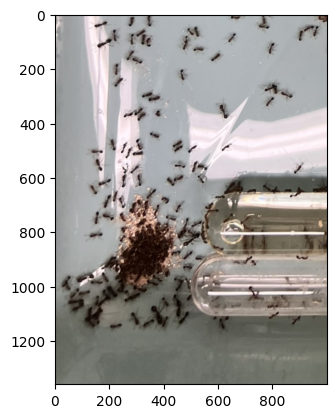

In [54]:
# crop [0:500, 0:1000] and resize to 1000x2000
img_crop = image_rgb[1500:, 0:500]
H, W = img_crop.shape[:2]
NEW_H, NEW_W = H * 2, W * 2
img_crop = cv2.resize(img_crop, (NEW_W, NEW_H))
plt.imshow(img_crop)

## SAM

In [55]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

In [56]:
# about 40 seconds
sam_result = mask_generator.generate(img_crop)

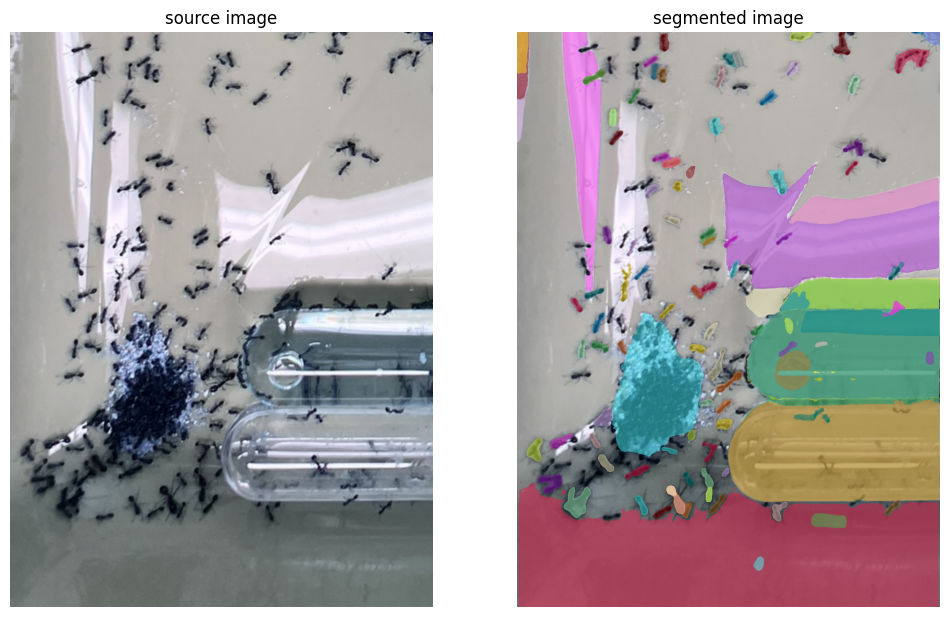

In [57]:
mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=img_crop.copy(), detections=detections)

sv.plot_images_grid(
    images=[img_crop, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)